## Learning Objectives:
1. [Gradient Descent](#Gradient-Descent)

2. [Classifying Handwritten Digits](#Classifying-Handwritten-Digits)
  - [Step1: Loading a Non-Linearly Separable Dataset](#Step1:-Loading-a-Non-Linearly-Separable-Dataset)
  - [Step2: Define a Multi-layer Proceptron (MLP) From Scratch](#Step2:-Define-a-Multi-layer-Proceptron-(MLP)-From-Scratch)
  - [Step3: Training (Backpropagation Algorithm)](#Step3:-Training-Stage (Backpropagation-Algorithm))
  - [Step4: Convergence Inspection](#Step4:-Convergence-Inspection)
  - [Step5: Testing (Handwritten Digits Classification)](#Step5:-Testing-(Handwritten-Digits-Classification))
  - [Step6: Evaluation](#Step6:-Evaluation)

3. [Impact of Learning Rate](#Impact-of-Learning-Rate)

4. [Regularization Parameter ‘$\lambda$’ on Synthetic Datasets](#Regularization-Parameter-‘$\lambda$’-on-Synthetic-Datasets)



#### Adapted from the following code repositories:
- Python Machine Learning 3rd Edition* by [Sebastian Raschka](https://sebastianraschka.com)
  - https://github.com/rasbt/python-machine-learning-book-3rd-edition/blob/master/ch12/ch12.ipynb
- Sklearn
  - https://scikit-learn.org/stable/auto_examples/neural_networks/plot_mlp_training_curves.html#sphx-glr-auto-examples-neural-networks-plot-mlp-training-curves-py

# Gradient Descent

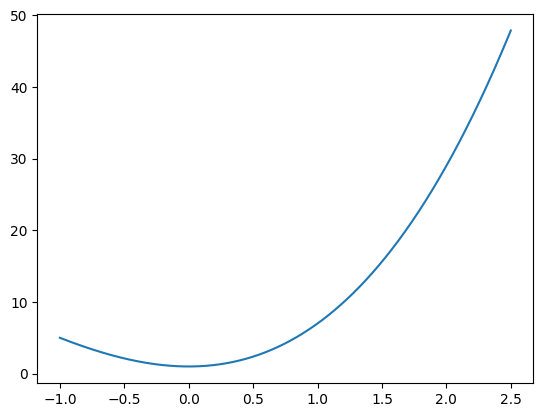

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import random
from scipy import stats
from scipy.optimize import fmin

import time
t0 = time.time()
seed = 42

Loss = lambda x: x**3+5*x**2+1

x = np.linspace(-1,2.5,1000)
plt.plot(x,Loss(x))
plt.show()

In [2]:
x_old = 0
x_new = 2 # The algorithm starts at x=2
n_k = 0.1 # learning rate
precision = 0.0001

x_list1, y_list1 = [x_new], [Loss(x_new)]

# returns the value of the derivative of our function
def f_prime(x):
    return 3*x**2+5*x
    # return 3*x**2-4*x

# loop until the change of x less or equal to precision
while abs(x_new - x_old) > precision:
    x_old = x_new
    s_k = f_prime(x_old)
    x_new = x_old - n_k * s_k
    x_list1.append(x_new)
    y_list1.append(Loss(x_new))
    
print("Case1: Learning rate:", n_k, "\tLocal minimum occurs at:", x_new, "\tNumber of steps:", len(x_list1))


x_old = 0
x_new = 2 # The algorithm starts at x=2
n_k = 0.01 # learning rate
x_list2, y_list2 = [x_new], [Loss(x_new)]

# loop until the change of x less or equal to precision
while abs(x_new - x_old) > precision:
    x_old = x_new
    s_k = f_prime(x_old)
    x_new = x_old - n_k * s_k
    x_list2.append(x_new)
    y_list2.append(Loss(x_new))
    
print("Case2: Learning rate:", n_k, "\tLocal minimum occurs at:", x_new, "\tNumber of steps:", len(x_list2))




x_old = 0
x_new = 2 # The algorithm starts at x=2
n_k = 0.001 # learning rate
x_list3, y_list3 = [x_new], [Loss(x_new)]

# loop until the change of x less or equal to precision
while abs(x_new - x_old) > precision:
    x_old = x_new
    s_k = f_prime(x_old)
    x_new = x_old - n_k * s_k
    x_list3.append(x_new)
    y_list3.append(Loss(x_new))
    
print("Case3: Learning rate:", n_k, "\tLocal minimum occurs at:", x_new, "\tNumber of steps:", len(x_list3))



Case1: Learning rate: 0.1 	Local minimum occurs at: -6.27530264859869e-05 	Number of steps: 14
Case2: Learning rate: 0.01 	Local minimum occurs at: 0.001852067929339952 	Number of steps: 121
Case3: Learning rate: 0.001 	Local minimum occurs at: 0.019601562037516982 	Number of steps: 768


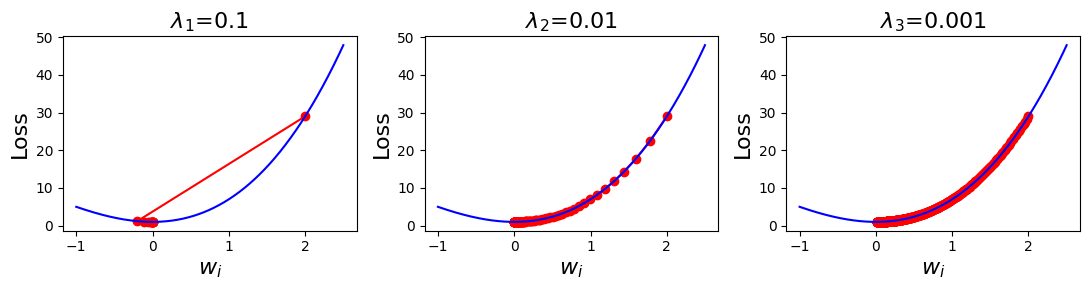

In [3]:
plt.figure(figsize=[11,3])
plt.subplot(1,3,1)
plt.scatter(x_list1,y_list1,c="r")
plt.plot(x_list1,y_list1,c="r")
plt.plot(x,Loss(x), c="b")
plt.xlabel('$w_i$', size=16)
plt.ylabel('Loss', size=16)
plt.title("$\lambda_1$=0.1", size=16)

plt.subplot(1,3,2)
plt.scatter(x_list2,y_list2,c="r")
plt.plot(x_list2,y_list2,c="r")
plt.plot(x,Loss(x), c="b")
plt.xlabel('$w_i$', size=16)
plt.ylabel('Loss', size=16)
plt.title("$\lambda_2$=0.01", size=16)

plt.subplot(1,3,3)
plt.scatter(x_list3,y_list3,c="r")
plt.plot(x_list3,y_list3,c="r")
plt.plot(x,Loss(x), c="b")
plt.xlabel('$w_i$', size=16)
plt.ylabel('Loss', size=16)
plt.title("$\lambda_3$=0.001", size=16)
# plt.show()
plt.tight_layout()
plt.savefig('gd.pdf', format='pdf')

# Classifying Handwritten Digits
## Step1: Loading a Non-Linearly Separable Dataset

In [28]:
import urllib.request
import os
import gzip
import numpy as np

def download_mnist(path):
    base_url = 'https://storage.googleapis.com/cvdf-datasets/mnist/'
    files = [
        'train-images-idx3-ubyte.gz', 'train-labels-idx1-ubyte.gz',
        't10k-images-idx3-ubyte.gz', 't10k-labels-idx1-ubyte.gz'
    ]
    
    if not os.path.exists(path):
        os.makedirs(path)
    
    for file in files:
        file_path = os.path.join(path, file)
        if not os.path.exists(file_path):
            print(f'Downloading {file}...')
            urllib.request.urlretrieve(base_url + file, file_path)
            with gzip.open(file_path, 'rb') as f_in:
                with open(file_path[:-3], 'wb') as f_out:
                    f_out.write(f_in.read())
            os.remove(file_path)

def load_mnist(path, kind='train'):
    labels_path = os.path.join(path, f'{kind}-labels-idx1-ubyte')
    images_path = os.path.join(path, f'{kind}-images-idx3-ubyte')
    
    with open(labels_path, 'rb') as lbpath:
        lbpath.read(8)
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8)
    
    with open(images_path, 'rb') as imgpath:
        imgpath.read(16)
        images = np.frombuffer(imgpath.read(), dtype=np.uint8).reshape(len(labels), 784)
    
    return images, labels

# Download and load the MNIST dataset
mnist_path = './MNIST_ORG'
download_mnist(mnist_path)

X_train, y_train = load_mnist(mnist_path, kind='train')
print('Rows: %d, columns: %d' % (X_train.shape[0], X_train.shape[1]))

X_test, y_test = load_mnist(mnist_path, kind='t10k')
print('Rows: %d, columns: %d' % (X_test.shape[0], X_test.shape[1]))

Rows: 60000, columns: 784
Rows: 10000, columns: 784


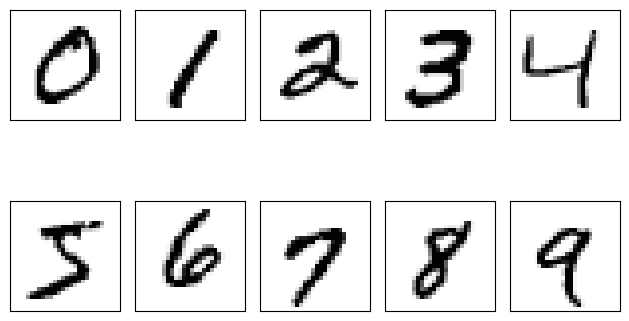

In [30]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(10):
    img = X_train[y_train == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

## Step2: Define a Multi-layer Proceptron (MLP) From Scratch
Implementation of a $n$-hidden layer Multi-layer perceptron from scratch using
 - sigmoid activation in the hidden layer
 - sigmoid activation in the output layer
 - Mean Squared Error loss function

In [34]:
import numpy as np
import sys


class NeuralNetMLP(object):
    """ Feedforward neural network / Multi-layer perceptron classifier.

    Parameters
    ------------
    n_hidden : int (default: 30)
        Number of hidden units.
    l2 : float (default: 0.)
        Lambda value for L2-regularization.
        No regularization if l2=0. (default)
    epochs : int (default: 100)
        Number of passes over the training set.
    eta : float (default: 0.001)
        Learning rate.
    shuffle : bool (default: True)
        Shuffles training data every epoch if True to prevent circles.
    minibatch_size : int (default: 1)
        Number of training examples per minibatch.
    seed : int (default: None)
        Random seed for initializing weights and shuffling.

    Attributes
    -----------
    eval_ : dict
      Dictionary collecting the cost, training accuracy,
      and validation accuracy for each epoch during training.

    """
    def __init__(self, n_hidden=30,
                 l2=0., epochs=100, eta=0.001,
                 shuffle=True, minibatch_size=1, seed=None):

        self.random = np.random.RandomState(seed)
        self.n_hidden = n_hidden
        self.l2 = l2
        self.epochs = epochs
        self.eta = eta
        self.shuffle = shuffle
        self.minibatch_size = minibatch_size

    def _onehot(self, y, n_classes):
        """Encode labels into one-hot representation

        Parameters
        ------------
        y : array, shape = [n_examples]
            Target values.
        n_classes : int
            Number of classes

        Returns
        -----------
        onehot : array, shape = (n_examples, n_labels)

        """
        onehot = np.zeros((n_classes, y.shape[0]))
        for idx, val in enumerate(y.astype(int)):
            onehot[val, idx] = 1.
        return onehot.T

    def _sigmoid(self, z):
        """Compute logistic function (sigmoid)"""
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))

    def _forward(self, X):
        """Compute forward propagation step"""

        # step 1: net input of hidden layer
        # [n_examples, n_features] dot [n_features, n_hidden]
        # -> [n_examples, n_hidden]
        z_h = np.dot(X, self.w_h) + self.b_h

        # step 2: activation of hidden layer
        a_h = self._sigmoid(z_h)

        # step 3: net input of output layer
        # [n_examples, n_hidden] dot [n_hidden, n_classlabels]
        # -> [n_examples, n_classlabels]

        z_out = np.dot(a_h, self.w_out) + self.b_out

        # step 4: activation output layer
        a_out = self._sigmoid(z_out)

        return z_h, a_h, z_out, a_out

    def _compute_cost(self, y_enc, output):
        """Compute cost function.

        Parameters
        ----------
        y_enc : array, shape = (n_examples, n_labels)
            one-hot encoded class labels.
        output : array, shape = [n_examples, n_output_units]
            Activation of the output layer (forward propagation)

        Returns
        ---------
        cost : float
            Regularized cost

        """
        L2_term = (self.l2 *
                   (np.sum(self.w_h ** 2.) +
                    np.sum(self.w_out ** 2.)))

        term1 = -y_enc * (np.log(output))
        term2 = (1. - y_enc) * np.log(1. - output)
        cost = np.sum(term1 - term2) + L2_term
        
        # If you are applying this cost function to other
        # datasets where activation
        # values maybe become more extreme (closer to zero or 1)
        # you may encounter "ZeroDivisionError"s due to numerical
        # instabilities in Python & NumPy for the current implementation.
        # I.e., the code tries to evaluate log(0), which is undefined.
        # To address this issue, you could add a small constant to the
        # activation values that are passed to the log function.
        #
        # For example:
        #
        # term1 = -y_enc * (np.log(output + 1e-5))
        # term2 = (1. - y_enc) * np.log(1. - output + 1e-5)
        
        return cost

    def predict(self, X):
        """Predict class labels

        Parameters
        -----------
        X : array, shape = [n_examples, n_features]
            Input layer with original features.

        Returns:
        ----------
        y_pred : array, shape = [n_examples]
            Predicted class labels.

        """
        z_h, a_h, z_out, a_out = self._forward(X)
        y_pred = np.argmax(z_out, axis=1)
        return y_pred

    def fit(self, X_train, y_train, X_valid, y_valid):
        """ Learn weights from training data.

        Parameters
        -----------
        X_train : array, shape = [n_examples, n_features]
            Input layer with original features.
        y_train : array, shape = [n_examples]
            Target class labels.
        X_valid : array, shape = [n_examples, n_features]
            Sample features for validation during training
        y_valid : array, shape = [n_examples]
            Sample labels for validation during training

        Returns:
        ----------
        self

        """
        n_output = np.unique(y_train).shape[0]  # number of class labels
        n_features = X_train.shape[1]

        ########################
        # Weight initialization
        ########################

        # weights for input -> hidden
        self.b_h = np.zeros(self.n_hidden)
        self.w_h = self.random.normal(loc=0.0, scale=0.1,
                                      size=(n_features, self.n_hidden))

        # weights for hidden -> output
        self.b_out = np.zeros(n_output)
        self.w_out = self.random.normal(loc=0.0, scale=0.1,
                                        size=(self.n_hidden, n_output))

        epoch_strlen = len(str(self.epochs))  # for progress formatting
        self.eval_ = {'cost': [], 'train_acc': [], 'valid_acc': []}

        y_train_enc = self._onehot(y_train, n_output)

        # iterate over training epochs
        for i in range(self.epochs):

            # iterate over minibatches
            indices = np.arange(X_train.shape[0])

            if self.shuffle:
                self.random.shuffle(indices)

            for start_idx in range(0, indices.shape[0] - self.minibatch_size +
                                   1, self.minibatch_size):
                batch_idx = indices[start_idx:start_idx + self.minibatch_size]

                # forward propagation
                z_h, a_h, z_out, a_out = self._forward(X_train[batch_idx])

                ##################
                # Backpropagation
                ##################

                # [n_examples, n_classlabels]
                delta_out = a_out - y_train_enc[batch_idx]

                # [n_examples, n_hidden]
                sigmoid_derivative_h = a_h * (1. - a_h)

                # [n_examples, n_classlabels] dot [n_classlabels, n_hidden]
                # -> [n_examples, n_hidden]
                delta_h = (np.dot(delta_out, self.w_out.T) *
                           sigmoid_derivative_h)

                # [n_features, n_examples] dot [n_examples, n_hidden]
                # -> [n_features, n_hidden]
                grad_w_h = np.dot(X_train[batch_idx].T, delta_h)
                grad_b_h = np.sum(delta_h, axis=0)

                # [n_hidden, n_examples] dot [n_examples, n_classlabels]
                # -> [n_hidden, n_classlabels]
                grad_w_out = np.dot(a_h.T, delta_out)
                grad_b_out = np.sum(delta_out, axis=0)

                # Regularization and weight updates
                delta_w_h = (grad_w_h + self.l2*self.w_h)
                delta_b_h = grad_b_h # bias is not regularized
                self.w_h -= self.eta * delta_w_h
                self.b_h -= self.eta * delta_b_h

                delta_w_out = (grad_w_out + self.l2*self.w_out)
                delta_b_out = grad_b_out  # bias is not regularized
                self.w_out -= self.eta * delta_w_out
                self.b_out -= self.eta * delta_b_out

            #############
            # Evaluation
            #############

            # Evaluation after each epoch during training
            z_h, a_h, z_out, a_out = self._forward(X_train)
            
            cost = self._compute_cost(y_enc=y_train_enc,
                                      output=a_out)

            y_train_pred = self.predict(X_train)
            y_valid_pred = self.predict(X_valid)

            train_acc = ((np.sum(y_train == y_train_pred)).astype(np.float64) /
                         X_train.shape[0])
            valid_acc = ((np.sum(y_valid == y_valid_pred)).astype(np.float64) /
                         X_valid.shape[0])

            sys.stderr.write('\r%0*d/%d | Cost: %.2f '
                             '| Train/Valid Acc.: %.2f%%/%.2f%% ' %
                             (epoch_strlen, i+1, self.epochs, cost,
                              train_acc*100, valid_acc*100))
            sys.stderr.flush()

            self.eval_['cost'].append(cost)
            self.eval_['train_acc'].append(train_acc)
            self.eval_['valid_acc'].append(valid_acc)

        return self

## Step3: Training: Backpropagation Algorithm

In [35]:
n_epochs = 200
nn = NeuralNetMLP(n_hidden=100, 
                  l2=0.01, 
                  epochs=n_epochs, 
                  eta=0.0005,
                  minibatch_size=100, 
                  shuffle=True,
                  seed=1)

nn.fit(X_train=X_train[:55000], 
       y_train=y_train[:55000],
       X_valid=X_train[55000:],
       y_valid=y_train[55000:])

200/200 | Cost: 15428.94 | Train/Valid Acc.: 96.02%/96.48% 

## Step4: Convergence Inspection

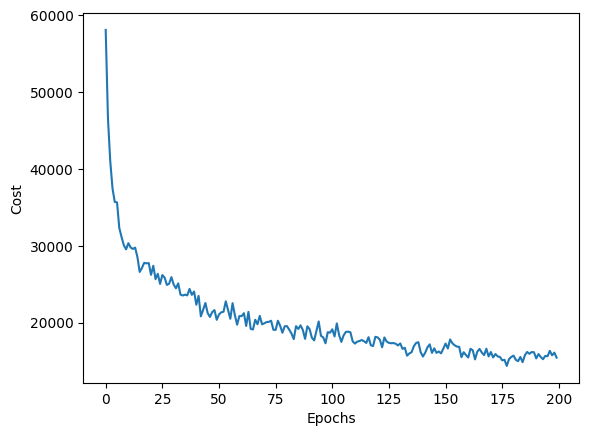

In [36]:
import matplotlib.pyplot as plt


plt.plot(range(nn.epochs), nn.eval_['cost'])
plt.ylabel('Cost')
plt.xlabel('Epochs')
#plt.savefig('images/12_07.png', dpi=300)
plt.show()

## Step5: Testing (Handwritten Digits Classification)

In [38]:
y_test_pred = nn.predict(X_test)
acc = (np.sum(y_test == y_test_pred)
       .astype(np.float64) / X_test.shape[0])

print('Test accuracy: %.2f%%' % (acc * 100))


Test accuracy: 95.66%


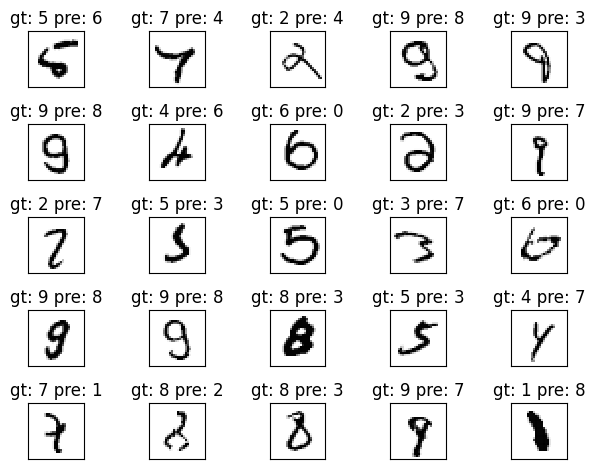

In [39]:
miscl_img = X_test[y_test != y_test_pred][:25]
correct_lab = y_test[y_test != y_test_pred][:25]
miscl_lab = y_test_pred[y_test != y_test_pred][:25]

fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(25):
    img = miscl_img[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title('gt: %d pre: %d' % (correct_lab[i], miscl_lab[i]))

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

## Step6: Evaluation

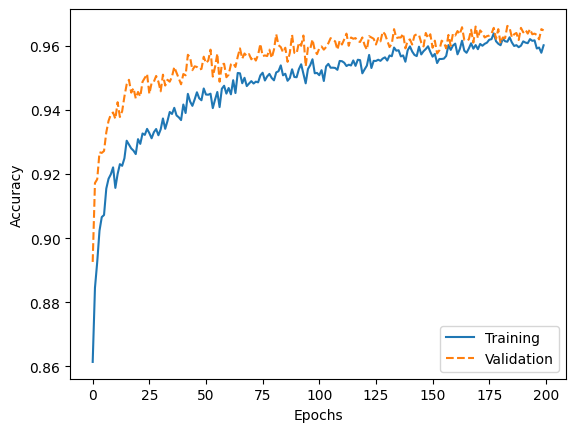

In [40]:
plt.plot(range(nn.epochs), nn.eval_['train_acc'], 
         label='Training')
plt.plot(range(nn.epochs), nn.eval_['valid_acc'], 
         label='Validation', linestyle='--')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
plt.show()

## Impact of Learning Rate

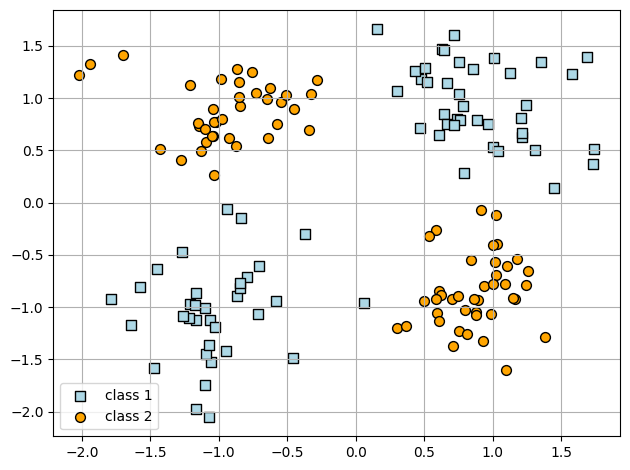

In [41]:
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('xor.csv')
X_train, X_test = df[['x1', 'x2']].values[0:150], df[['x1', 'x2']].values[151:300]
y_train, y_test = df['class label'].values[0:150], df['class label'].values[151:300]


sc = StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)

plt.scatter(X_train[y_train == 0, 0],
            X_train[y_train == 0, 1],
            s=50, c='lightblue',
            marker='s', edgecolor='black',
            label='class 1')
plt.scatter(X_train[y_train == 1, 0],
            X_train[y_train == 1, 1],
            s=50, c='orange',
            marker='o', edgecolor='black',
            label='class 2')

plt.legend(scatterpoints=1)
plt.grid()
plt.tight_layout()
plt.show()




learning on dataset XOR Dataset
training: learning rate 0.1
Training set score: 0.973333
Training set loss: 0.535981
training: learning rate 0.5
Training set score: 0.993333
Training set loss: 0.062435
training: learning rate 1.0
Training set score: 0.993333
Training set loss: 0.033478
training: adam 0.01
Training set score: 1.000000
Training set loss: 0.019954


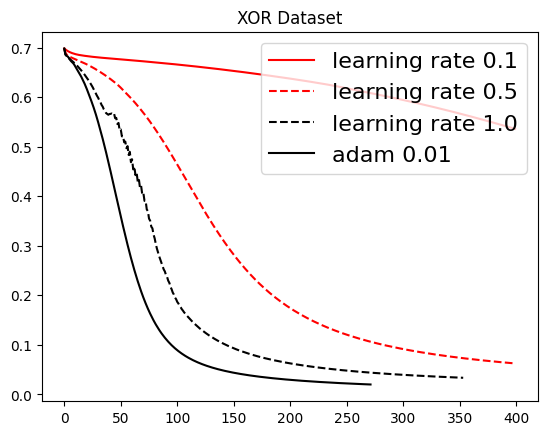

In [42]:
import warnings

import matplotlib.pyplot as plt

from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn import datasets
from sklearn.exceptions import ConvergenceWarning

# different learning rate schedules and momentum parameters
params = [
    {
        "solver": "sgd",
        "learning_rate": "constant",
        "momentum": 0,
        "learning_rate_init": 0.1,
    },
    {
        "solver": "sgd",
        "learning_rate": "constant",
        "momentum": 0,
        "learning_rate_init": 0.5,
    },
    {
        "solver": "sgd",
        "learning_rate": "constant",
        "momentum": 0,
        "learning_rate_init": 1.0,
    },
    {"solver": "adam", "learning_rate_init": 0.01},
]

labels = [
    "learning rate 0.1",
    "learning rate 0.5",
    "learning rate 1.0",
    "adam 0.01",
]

plot_args = [
    {"c": "red", "linestyle": "-"},
    {"c": "red", "linestyle": "--"},
    {"c": "black", "linestyle": "--"},
    {"c": "black", "linestyle": "-"},
]


def plot_on_dataset(X, y, name):
    # for each dataset, plot learning for each learning strategy
    print("\nlearning on dataset %s" % name)
    plt.title(name)

    X = MinMaxScaler().fit_transform(X)
    mlps = []
    if name == "digits":
        # digits is larger but converges fairly quickly
        max_iter = 15
    else:
        max_iter = 400

    for label, param in zip(labels, params):
        print("training: %s" % label)
        mlp = MLPClassifier(random_state=0, max_iter=max_iter, **param)

        # some parameter combinations will not converge as can be seen on the
        # plots so they are ignored here
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore", category=ConvergenceWarning, module="sklearn"
            )
            mlp.fit(X, y)

        mlps.append(mlp)
        print("Training set score: %f" % mlp.score(X, y))
        print("Training set loss: %f" % mlp.loss_)
    for mlp, label, args in zip(mlps, labels, plot_args):
        plt.plot(mlp.loss_curve_, label=label, **args)


plot_on_dataset(X_train, y_train, name="XOR Dataset")

plt.legend(labels, ncol=1, loc="upper right", fontsize=16)
plt.show()

## Regularization Parameter ‘$\lambda$’ on Synthetic Datasets 

$\lambda$ is a parameter for regularization term that combats overfitting by constraining the size of the weights. 
* Increasing $\lambda$ may fix overfitting by encouraging smaller weights. Resulting in a smoother decision boundary. 
* Decreasing $\lambda$ may fix underfitting by encouraging larger weights. Resulting in a more complicated decision boundary.

/var/folders/q8/gtyqzz1155g79bwcvr1x527c0000gq/T/ipykernel_20510/4213911827.py:78: UserWarning: You passed a edgecolor/edgecolors ('blue') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x=X_test[y_test == cl, 0],
/var/folders/q8/gtyqzz1155g79bwcvr1x527c0000gq/T/ipykernel_20510/4213911827.py:78: UserWarning: You passed a edgecolor/edgecolors ('red') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x=X_test[y_test == cl, 0],
/var/folders/q8/gtyqzz1155g79bwcvr1x527c0000gq/T/ipykernel_20510/4213911827.py:120: UserWarning: You passed a edgecolor/edgecolors ('blue') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x=X_test[y_test == cl, 0],
/var/folders/q8/gtyqzz1155g79bwcvr1x527c0000gq/T/ipyker

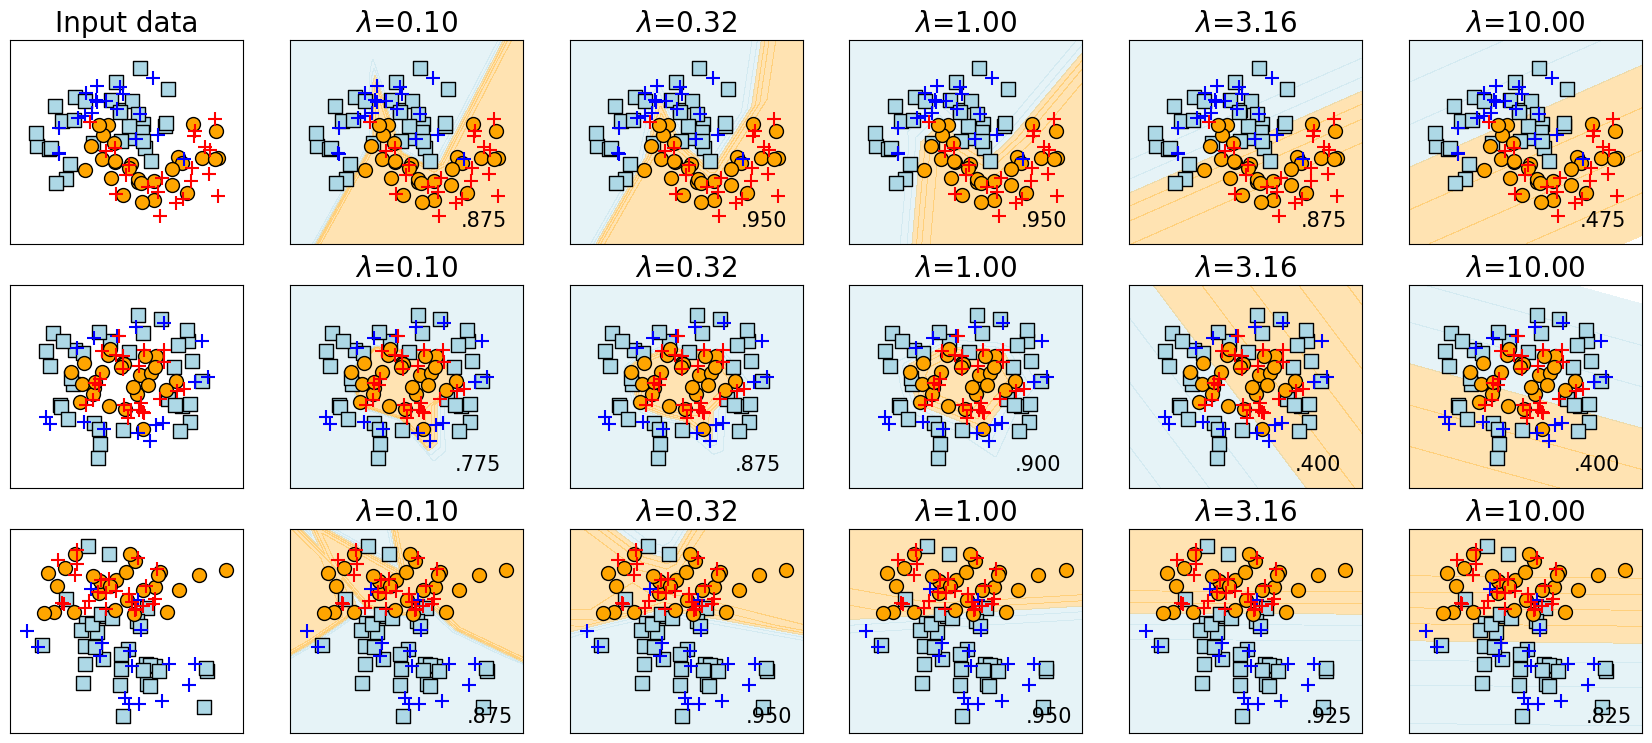

In [43]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline

h = 0.02  # step size in the mesh

alphas = np.logspace(-1, 1, 5)

classifiers = []
names = []
for alpha in alphas:
    classifiers.append(
        make_pipeline(
            StandardScaler(),
            MLPClassifier(
                solver="lbfgs",
                alpha=alpha,
                random_state=1,
                max_iter=2000,
                early_stopping=True,
                hidden_layer_sizes=[10, 10],
            ),
        )
    )
    names.append(f"$\lambda$={alpha:.2f}")

X, y = make_classification(
    n_features=2, n_redundant=0, n_informative=2, random_state=0, n_clusters_per_class=1
)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [
    make_moons(noise=0.3, random_state=0),
    make_circles(noise=0.2, factor=0.5, random_state=1),
    linearly_separable,
]

figure = plt.figure(figsize=(17, 9))
i = 1
# iterate over datasets
for ds_cnt, (X, y) in enumerate(datasets):
    # split into training and test part
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.4, random_state=42
    )

    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # just plot the dataset first
#     cm = plt.cm.RdBu
#     cm_bright = ListedColormap(["#FF0000", "#0000FF"])

    markers = ('s', 'o', '+', '+', 'v')
    colors = ('lightblue', 'orange', 'blue', 'red')
    cmap = ListedColormap(colors[:2])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data", size=20)
    # Plot the training points
    for idx, cl in enumerate(np.unique(y_train)):
        ax.scatter(x=X_train[y_train == cl, 0], 
                            y=X_train[y_train == cl, 1],
                            s=100, 
                            color=colors[idx],
                            marker=markers[idx], 
                            edgecolor='black')
    # and testing points
    for idx, cl in enumerate(np.unique(y_test)):
        ax.scatter(x=X_test[y_test == cl, 0], 
                            y=X_test[y_test == cl, 1],
                            s=100, 
                            color=colors[idx+2],
                            marker='+', 
                            edgecolor=colors[idx+2])
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max] x [y_min, y_max].
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.column_stack([xx.ravel(), yy.ravel()]))
        else:
            Z = clf.predict_proba(np.column_stack([xx.ravel(), yy.ravel()]))[:, 1]

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cmap, alpha=0.3)

        
        # Plot the training points
        for idx, cl in enumerate(np.unique(y_train)):
            ax.scatter(x=X_train[y_train == cl, 0], 
                            y=X_train[y_train == cl, 1],
                            alpha=1, 
                            s=100, 
                            color=colors[idx],
                            marker=markers[idx], 
                            edgecolor='black')

        # Plot the testing points
        for idx, cl in enumerate(np.unique(y_test)):
            ax.scatter(x=X_test[y_test == cl, 0], 
                            y=X_test[y_test == cl, 1],
                            alpha=1, 
                            s=100, 
                            color=colors[idx+2],
                            marker='+', 
                            edgecolor=colors[idx+2])

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        ax.set_title(name, size=20)
        ax.text(
            xx.max() - 0.3,
            yy.min() + 0.3,
            f"{score:.3f}".lstrip("0"),
            size=15,
            horizontalalignment="right",
        )
        i += 1

figure.subplots_adjust(left=0.02, right=0.98)
plt.show()